In [2]:
# Firstly, some necessary imports

# Jupyter notebook related
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Imports from eo-learn and sentinelhub-py
from eolearn.core.eoworkflow import LinearWorkflow, Dependency
from eolearn.core.eodata import FeatureType
from sentinelhub import BBox, CRS
import numpy as np
import matplotlib.pyplot as plt
import datetime
from eolearn.core import SaveToDisk, LoadFromDisk
from eolearn.io import S2L1CWCSInput, AddSen2CorClassificationFeature, DEMWCSInput, S2L2AWCSInput, L8L1CWCSInput, SentinelHubWMSInput, SentinelHubWCSInput
from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox, DataSource, constants, BBoxSplitter

In [5]:
# Firstly, some necessary imports

# Jupyter notebook related
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Built-in modules
import pickle
import sys
import os
import datetime
import itertools
from aenum import MultiValueEnum

# Basics of Python data handling and visualization
import numpy as np
np.random.seed(42)
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap, BoundaryNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Polygon
from tqdm.auto import tqdm

# Machine learning
import lightgbm as lgb
from sklearn.externals import joblib
from sklearn import metrics
from sklearn import preprocessing

# Imports from eo-learn and sentinelhub-py
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, OverwritePermission, \
    LoadTask, SaveTask, EOExecutor, ExtractBandsTask, MergeFeatureTask
from eolearn.io import SentinelHubInputTask, ExportToTiff
from eolearn.mask import AddMultiCloudMaskTask, AddValidDataMaskTask
from eolearn.geometry import VectorToRaster, PointSamplingTask, ErosionTask
from eolearn.features import LinearInterpolation, SimpleFilterTask, NormalizedDifferenceIndexTask
from sentinelhub import UtmZoneSplitter, BBox, CRS, DataSource

/home/doma/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [6]:
from sentinelhub import SHConfig


INSTANCE_ID = 'da9a30c7-00e2-4dde-88a0-bdcd480e106f'  # In case you put instance ID into configuration file you can leave this unchanged

if INSTANCE_ID:
    config = SHConfig()
    config.instance_id = INSTANCE_ID
else:
    config = None

Dimension of the area is 243184 x 161584 m2


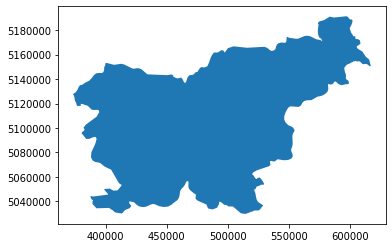

In [87]:
#example
# Load geojson file
country = gpd.read_file('svn_border.geojson')
country = country.buffer(500)
# Get the country's shape in polygon format
country_shape = country.geometry.values[-1]
# Plot country
country.plot()
#plt.axis('off');

# Print size
print('Dimension of the area is {0:.0f} x {1:.0f} m2'.format(country_shape.bounds[2] - country_shape.bounds[0],
                                                             country_shape.bounds[3] - country_shape.bounds[1]))


In [113]:
info_list[0],country.crs

({'crs': 'UTM_33N',
  'utm_zone': '33',
  'utm_row': '',
  'direction': 'N',
  'index': 0,
  'index_x': 0,
  'index_y': 19},
 <Projected CRS: EPSG:32633>
 Name: WGS 84 / UTM zone 33N
 Axis Info [cartesian]:
 - E[east]: Easting (metre)
 - N[north]: Northing (metre)
 Area of Use:
 - name: World - N hemisphere - 12°E to 18°E - by country
 - bounds: (12.0, 0.0, 18.0, 84.0)
 Coordinate Operation:
 - name: UTM zone 33N
 - method: Transverse Mercator
 Datum: World Geodetic System 1984
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich)

In [112]:
# Create the splitter to obtain a list of bboxes
bbox_splitter = UtmZoneSplitter([country_shape], country.crs, 5000)

bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())

# Prepare info of selected EOPatches
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list]
idxs = [info['index'] for info in info_list]
idxs_x = [info['index_x'] for info in info_list]
idxs_y = [info['index_y'] for info in info_list]

gdf = gpd.GeoDataFrame({'index': idxs, 'index_x': idxs_x, 'index_y': idxs_y},
                           crs=country.crs,
                           geometry=geometry)

# select a 5x5 area (id of center patch)
ID = 616

# Obtain surrounding 5x5 patches
patchIDs = []
for idx, [bbox, info] in enumerate(zip(bbox_list, info_list)):
    if (abs(info['index_x'] - info_list[ID]['index_x']) <= 2 and
        abs(info['index_y'] - info_list[ID]['index_y']) <= 2):
        patchIDs.append(idx)

# Check if final size is 5x5
if len(patchIDs) != 5*5:
    print('Warning! Use a different central patch ID, this one is on the border.')

# Change the order of the patches (used for plotting later)
patchIDs = np.transpose(np.fliplr(np.array(patchIDs).reshape(5, 5))).ravel()

# save to shapefile
shapefile_name = './grid_slovenia_500x500.gpkg'
gdf.to_file(shapefile_name, driver='GPKG')

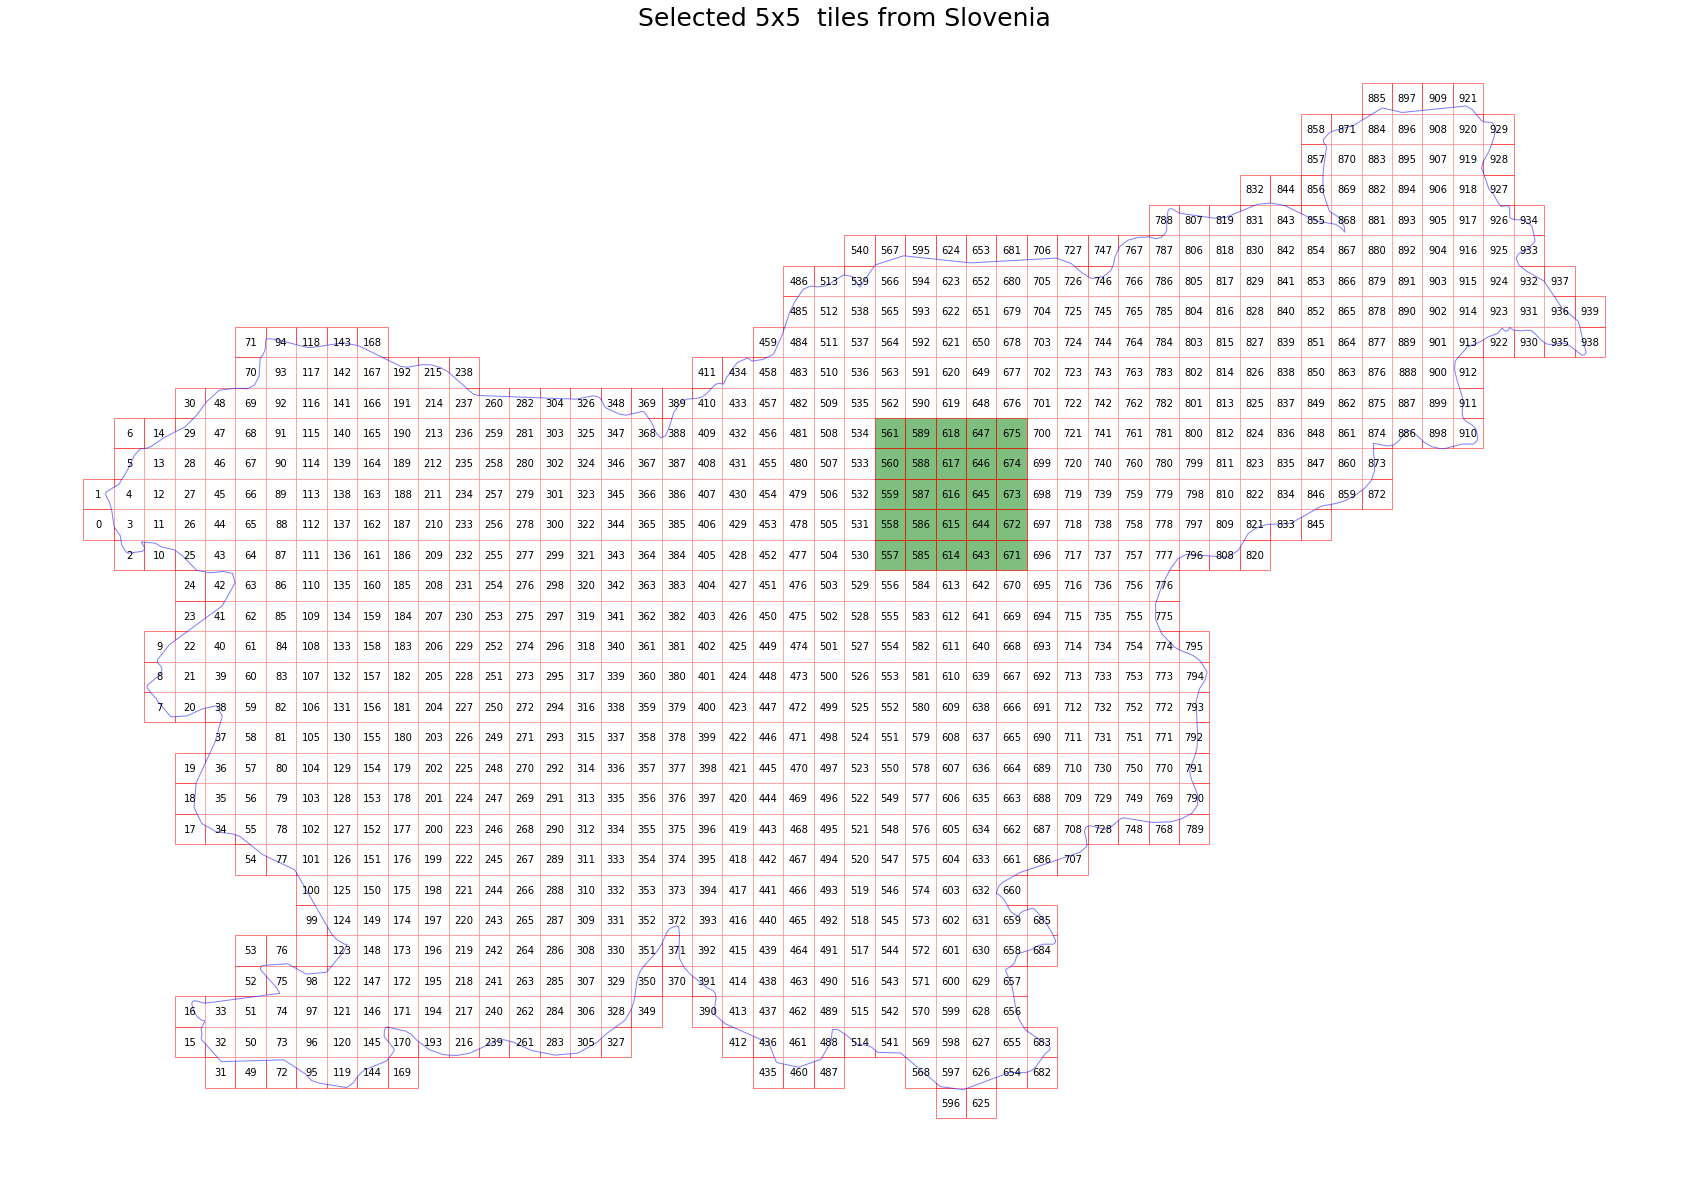

In [10]:
# figure
fig, ax = plt.subplots(figsize=(30, 30))
gdf.plot(ax=ax,facecolor='w',edgecolor='r',alpha=0.5)
country.plot(ax=ax, facecolor='w',edgecolor='b',alpha=0.5)
ax.set_title('Selected 5x5  tiles from Slovenia', fontsize=25);
for bbox, info in zip(bbox_list, info_list):
    geo = bbox.geometry
    ax.text(geo.centroid.x, geo.centroid.y, info['index'], ha='center', va='center')

gdf[gdf.index.isin(patchIDs)].plot(ax=ax,facecolor='g',edgecolor='r',alpha=0.5)

plt.axis('off');

In [11]:
#recreate with our data
#Tres Cantos Spain
delta=0.004
delta_lat=0.003
top_left_lat = 40.608715 - delta_lat
top_left_long = -3.727144 + delta
bottom_right_lat = 40.590063 +delta_lat
bottom_right_long = -3.701583 -delta
coords_wgs84 = [top_left_long, top_left_lat, bottom_right_long, bottom_right_lat]
coords_wgs84 = BBox(bbox=coords_wgs84, crs=CRS.WGS84)

In [16]:
#parallelo tra coords_wgs84 e country shape
type(country), type(country_shape), country.crs


(geopandas.geoseries.GeoSeries,
 shapely.geometry.polygon.Polygon,
 <Projected CRS: EPSG:32633>
 Name: WGS 84 / UTM zone 33N
 Axis Info [cartesian]:
 - E[east]: Easting (metre)
 - N[north]: Northing (metre)
 Area of Use:
 - name: World - N hemisphere - 12°E to 18°E - by country
 - bounds: (12.0, 0.0, 18.0, 84.0)
 Coordinate Operation:
 - name: UTM zone 33N
 - method: Transverse Mercator
 Datum: World Geodetic System 1984
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich)

In [129]:
area = gpd.GeoSeries(coords_wgs84.geometry)
area.crs = "EPSG:4326"
area_shape = area.geometry.values[-1]
type(area) ,type(area_shape), area.crs

(geopandas.geoseries.GeoSeries,
 shapely.geometry.polygon.Polygon,
 <Geographic 2D CRS: EPSG:4326>
 Name: WGS 84
 Axis Info [ellipsoidal]:
 - Lat[north]: Geodetic latitude (degree)
 - Lon[east]: Geodetic longitude (degree)
 Area of Use:
 - name: World
 - bounds: (-180.0, -90.0, 180.0, 90.0)
 Datum: World Geodetic System 1984
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich)

Dimension of the area is 1497 x 1416 m2


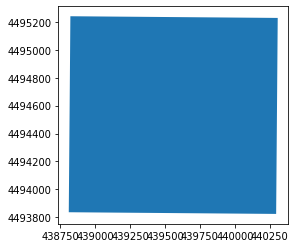

In [171]:
#project
#area = area.to_crs("EPSG:3035")
area = area.to_crs("EPSG:32627")#27N
area = area.to_crs("EPSG:32630")#30N

area_shape = area.geometry.values[-1]
area_shape._crs = area.crs
# Plot
area.plot()
#plt.axis('off');

# Print size
print('Dimension of the area is {0:.0f} x {1:.0f} m2'.format(area_shape.bounds[2] - area_shape.bounds[0],
                                                             area_shape.bounds[3] - area_shape.bounds[1]))

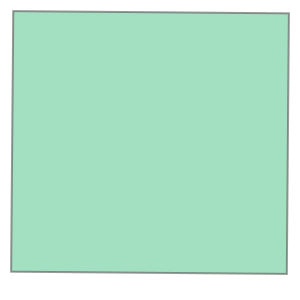

In [172]:
area_shape

In [173]:
area.crs

<Projected CRS: EPSG:32630>
Name: WGS 84 / UTM zone 30N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 6°W to 0°W - by country
- bounds: (-6.0, 0.0, 0.0, 84.0)
Coordinate Operation:
- name: UTM zone 30N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [175]:
info_list[0],area.crs

({'crs': 'UTM_30N',
  'utm_zone': '30',
  'utm_row': '',
  'direction': 'N',
  'index': 0,
  'index_x': 0,
  'index_y': 0},
 <Projected CRS: EPSG:32630>
 Name: WGS 84 / UTM zone 30N
 Axis Info [cartesian]:
 - E[east]: Easting (metre)
 - N[north]: Northing (metre)
 Area of Use:
 - name: World - N hemisphere - 6°W to 0°W - by country
 - bounds: (-6.0, 0.0, 0.0, 84.0)
 Coordinate Operation:
 - name: UTM zone 30N
 - method: Transverse Mercator
 Datum: World Geodetic System 1984
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich)

In [174]:
# Create the splitter to obtain a list of bboxes
bbox_splitter = UtmZoneSplitter([area_shape], "EPSG:32630", 50)

bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())
bbox_list[0]._crs

CRS('32630')

In [176]:
# Create the splitter to obtain a list of bboxes
bbox_splitter = UtmZoneSplitter([area_shape], area.crs, 50)

bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())

# Prepare info of selected EOPatches
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list]
idxs = [info['index'] for info in info_list]
idxs_x = [info['index_x'] for info in info_list]
idxs_y = [info['index_y'] for info in info_list]

gdf = gpd.GeoDataFrame({'index': idxs, 'index_x': idxs_x, 'index_y': idxs_y},
                           crs=area.crs,
                           geometry=geometry)

# select a 5x5 area (id of center patch)
ID = 200

# Obtain surrounding 5x5 patches
patchIDs = []
for idx, [bbox, info] in enumerate(zip(bbox_list, info_list)):
    if (abs(info['index_x'] - info_list[ID]['index_x']) <= 2 and
        abs(info['index_y'] - info_list[ID]['index_y']) <= 2):
        patchIDs.append(idx)

# Check if final size is 5x5
if len(patchIDs) != 5*5:
    print('Warning! Use a different central patch ID, this one is on the border.')

# Change the order of the patches (used for plotting later)
patchIDs = np.transpose(np.fliplr(np.array(patchIDs).reshape(5, 5))).ravel()

# save to shapefile
shapefile_name = './grid_slovenia_500x500.gpkg'
gdf.to_file(shapefile_name, driver='GPKG')

In [177]:
gdf._crs

<Projected CRS: EPSG:32630>
Name: WGS 84 / UTM zone 30N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 6°W to 0°W - by country
- bounds: (-6.0, 0.0, 0.0, 84.0)
Coordinate Operation:
- name: UTM zone 30N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [178]:
area[0].bounds

(438809.7219719687, 4493824.004728704, 440306.9485303416, 4495240.472154984)

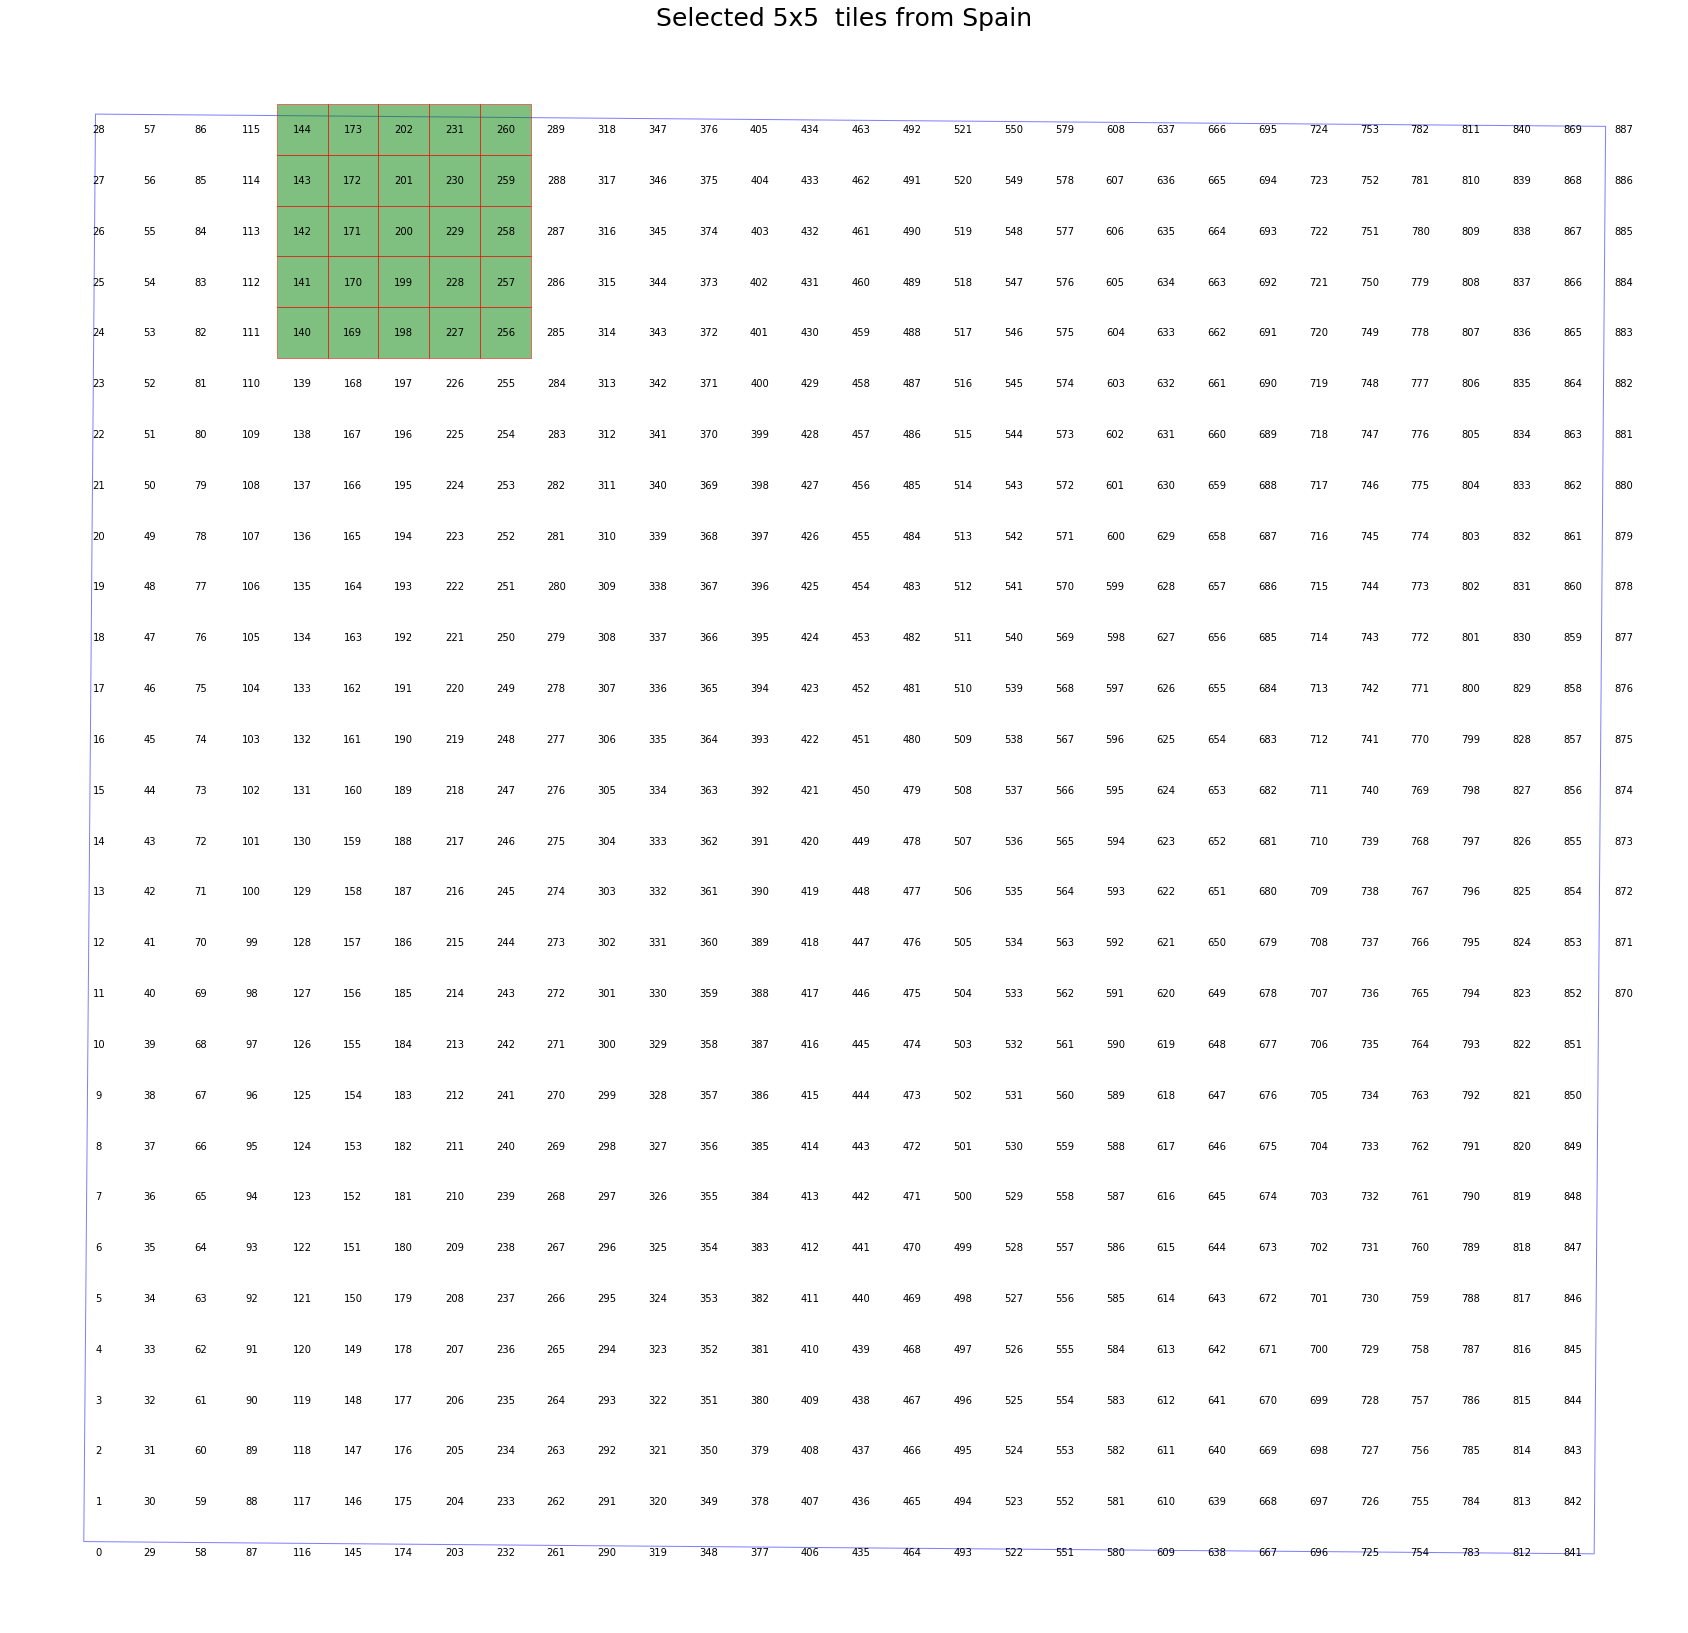

In [182]:
# figure
fig, ax = plt.subplots(figsize=(30, 30))
#gdf.plot(ax=ax,facecolor='w',edgecolor='r',alpha=0.5)
area.plot(ax=ax, facecolor='w',edgecolor='b',alpha=0.5)
ax.set_title('Selected 5x5  tiles from Spain', fontsize=25);
for bbox, info in zip(bbox_list, info_list):
    geo = bbox.geometry
    ax.text(geo.centroid.x, geo.centroid.y, info['index'], ha='center', va='center')

gdf[gdf.index.isin(patchIDs)].plot(ax=ax,facecolor='g',edgecolor='r',alpha=0.5)

plt.axis('off');

In [186]:
#let's load data
layer = 'TRUE-COLOR'

collection_id = 'cd0bc245-5d71-41aa-bb72-c09f8e89a53c'

input_task = SentinelHubWCSInput(
    data_source=DataSource(collection_id),
    layer=layer,
    resx='0.3m',
    resy='0.3m',
    instance_id = 'dd060ae7-b4ff-4576-a1e6-8d5f18514ebf'
)


save = SaveTask('io_example', overwrite_permission=2, compress_level=1)

workflow = LinearWorkflow(
    input_task,
    save
)

# Let's visualize it
#workflow.dependency_graph()

In [187]:
%%time

# Execute the workflow
time_interval = ('2018-04-01', '2021-05-01')

# define additional parameters of the workflow
execution_args = []
for idx, bbox in enumerate(bbox_list[patchIDs]):
    execution_args.append({
        input_task:{'bbox': bbox, 'time_interval': time_interval},
        save: {'eopatch_folder': f'eopatch_{idx}'}
    })

executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=12, multiprocess=False)

executor.make_report()



/home/doma/anaconda3/lib/python3.7/site-packages/sentinelhub/data_request.py:47: SHDeprecationWarning: Parameter 'instance_id' is deprecated and will soon removed. Use parameter 'config' instead
  category=SHDeprecationWarning)



CPU times: user 3.82 s, sys: 638 ms, total: 4.45 s
Wall time: 6.28 s


/home/doma/anaconda3/lib/python3.7/site-packages/eolearn/core/eoexecution.py:282: Warning: failed to execute ['dot', '-Tpng'], make sure the Graphviz executables are on your systems' PATH.
Please install the system package 'graphviz' (in addition to the python package) to have the dependency graph in the final report!
  return EOExecutorVisualization(self).make_report()


In [189]:
EOPatch.load('./io_example/eopatch_0/')

EOPatch(
  data: {
    TRUE-COLOR: numpy.ndarray(shape=(2, 167, 167, 3), dtype=float32)
  }
  mask: {
    IS_DATA: numpy.ndarray(shape=(2, 167, 167, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 1.0
    service_type: 'wcs'
    size_x: '0.3m'
    size_y: '0.3m'
    time_difference: datetime.timedelta(days=-1, seconds=86399)
    time_interval: ('2018-04-01', '2021-05-01')
  }
  bbox: BBox(((439000.0, 4495200.0), (439050.0, 4495250.0)), crs=CRS('32630'))
  timestamp: [datetime.datetime(2020, 2, 28, 11, 23, 42), datetime.datetime(2020, 3, 29, 11, 20, 26)]
)

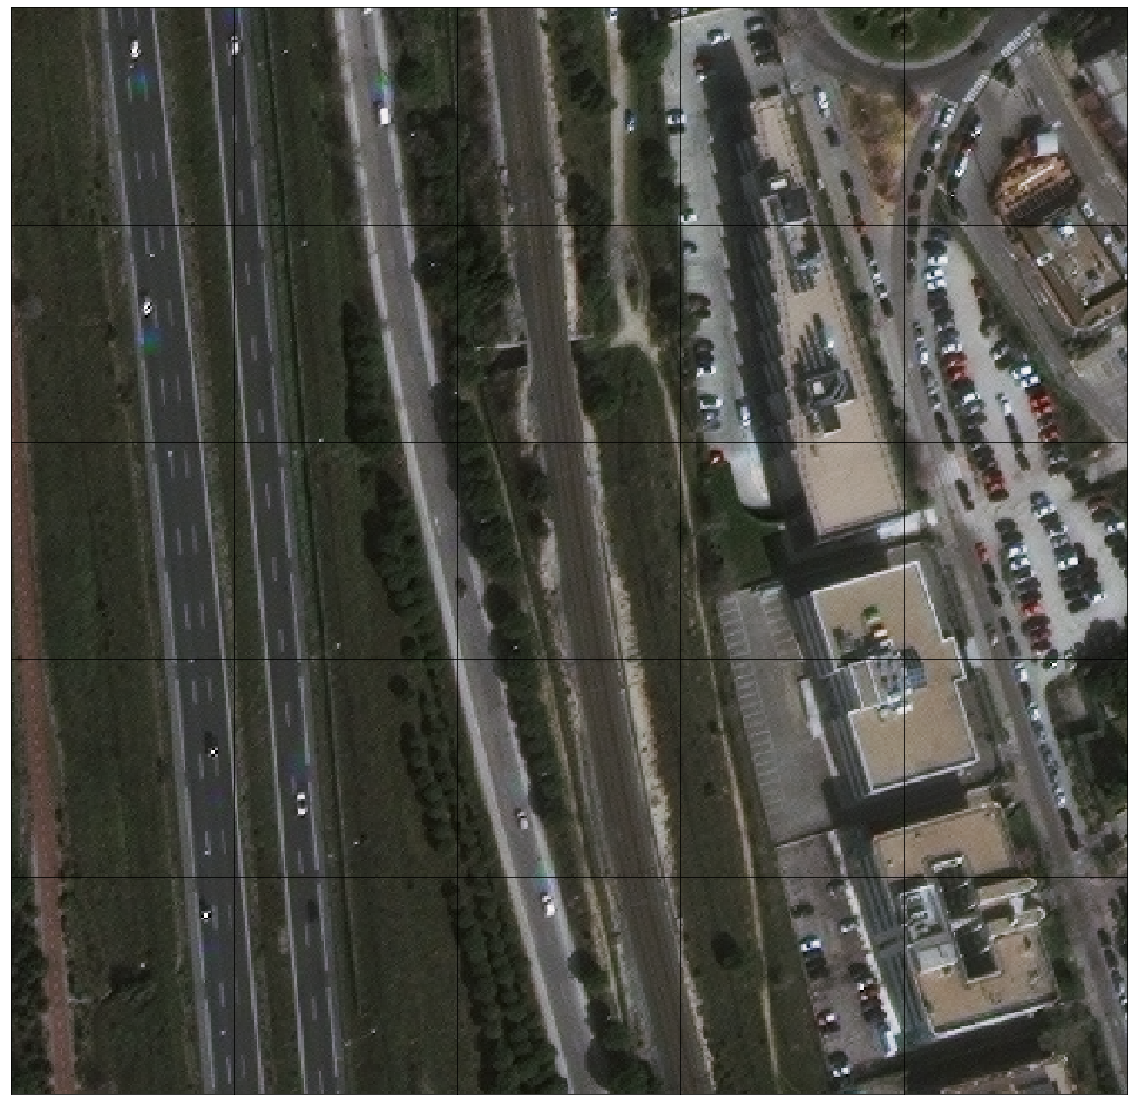

In [191]:
# Draw the RGB image
path_out = './io_example'
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

date = datetime.datetime(2019,7,1)

for i in tqdm(range(len(patchIDs))):
    eopatch = EOPatch.load(f'{path_out}/eopatch_{i}', lazy_loading=True)
    ax = axs[i//5][i%5]
    dates = np.array(eopatch.timestamp)
    closest_date_id = np.argsort(abs(date-dates))[0]
    ax.imshow(eopatch.data['TRUE-COLOR'][0])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

-3.723144,40.593063,-3.705583,40.605715


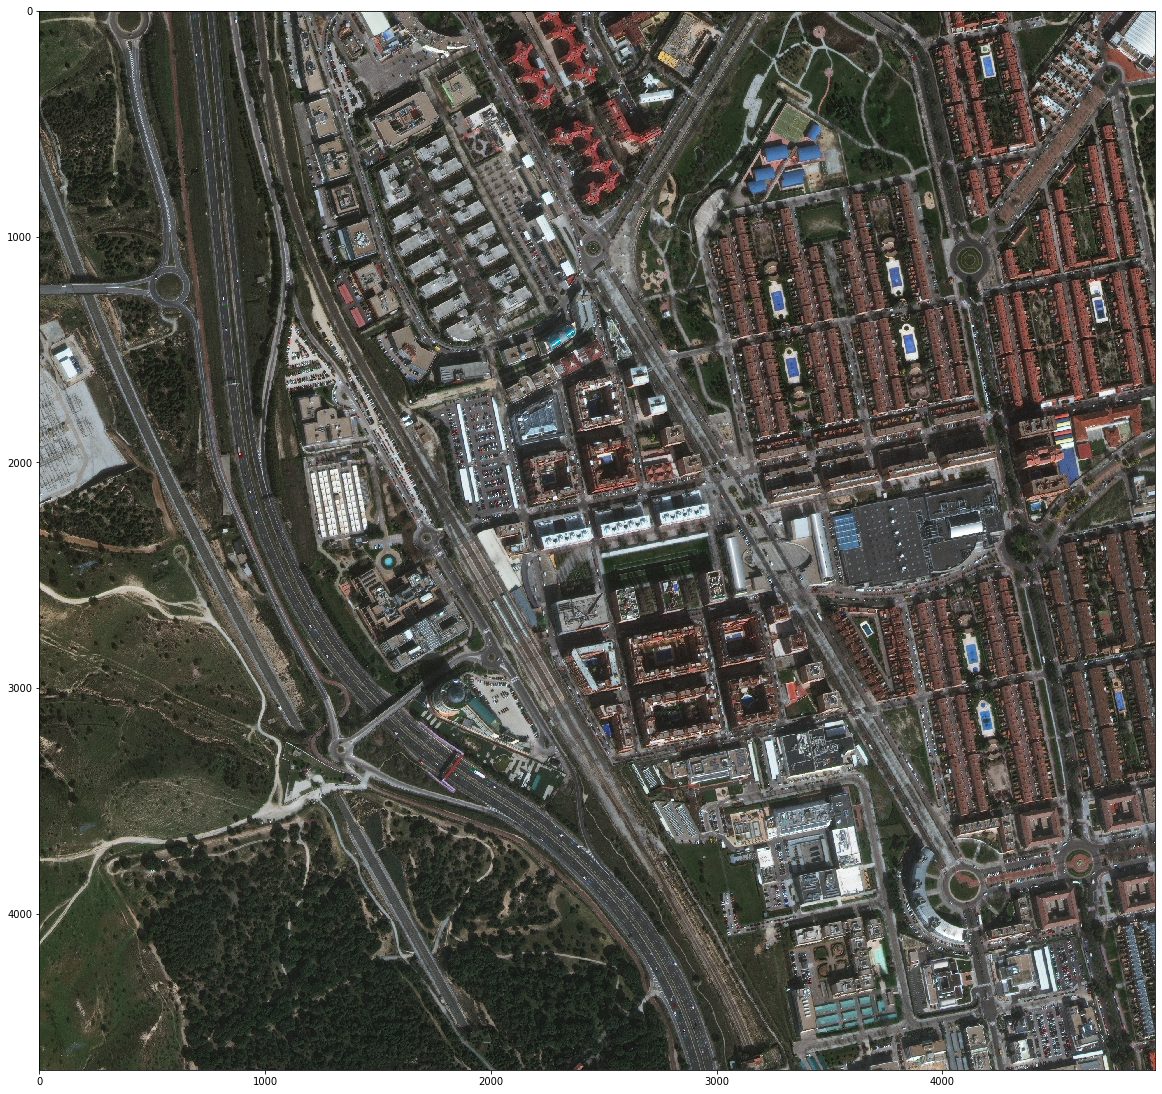

In [193]:
def plot_image(image, factor=1):
    """
    Utility function for plotting RGB images.
    """
    fig = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))
    plt.imshow(image)
#Tres Cantos Spain
delta=0.004
delta_lat=0.003
top_left_lat = 40.608715 - delta_lat
top_left_long = -3.727144 + delta
bottom_right_lat = 40.590063 +delta_lat
bottom_right_long = -3.701583 -delta
coords_wgs84 = [top_left_long, top_left_lat, bottom_right_long, bottom_right_lat]
coords_wgs84 = BBox(bbox=coords_wgs84, crs=CRS.WGS84)
print(coords_wgs84)

#european imaging (30cm!)
instance_id = 'dd060ae7-b4ff-4576-a1e6-8d5f18514ebf'
layer = 'TRUE-COLOR'
#layer = '1_TRUE-COLOR'
config = SHConfig()
config.instance_id = instance_id
collection_id = 'cd0bc245-5d71-41aa-bb72-c09f8e89a53c'


wcs_true_color_request = WcsRequest(
    data_source=DataSource(collection_id),
    data_folder='tres_cantos_tiff',
    layer=layer,
    bbox=coords_wgs84,
    time=('2016-01-01', '2021-01-01'),
    image_format=constants.MimeType.TIFF_d8,
    resx='0.3m',
    resy='0.3m',
    config=config
)
wcs_true_color_data = wcs_true_color_request.get_data(save_data=True)
plot_image(wcs_true_color_data[0])
